In [1]:
import requests
import re
import json
from urllib.parse import urljoin
from bs4 import BeautifulSoup
import _thread
import time
import jieba
import jieba.analyse
from collections import Counter
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt

# PTT 八卦版網址
#PTT_URL = 'https://www.ptt.cc/bbs/Gossiping/index.html'
PTT_URL = 'https://www.ptt.cc/bbs/HatePolitics/index.html'

In [2]:
def crawl_article(url):
    response = requests.get(url, cookies={'over18': '1'})
    response.encoding = 'utf-8'

    # 假設網頁回應不是 200 OK 的話, 我們視為傳送請求失敗
    if response.status_code != 200:
        print('Error - {} is not available to access'.format(url))
        return

    # 將網頁回應的 HTML 傳入 BeautifulSoup 解析器, 方便我們根據標籤 (tag) 資訊去過濾尋找
    soup = BeautifulSoup(response.text, 'html5lib')

    # 取得文章內容主體
    main_content = soup.find(id='main-content')

    # 假如文章有屬性資料 (meta), 我們在從屬性的區塊中爬出作者 (author), 文章標題 (title), 發文日期 (date)
    metas = main_content.select('div.article-metaline')
    author = ''
    title = ''
    date = ''
    author_id = ''
    author_name = ''
    if metas:
        if metas[0].select('span.article-meta-value')[0]:
            author = metas[0].select('span.article-meta-value')[0].string
            author_separate = author.split(' ')
            author_id = author_separate[0].strip()
            
            if len(author_separate) > 1:
                author_name = author_separate[1].strip()[1:-1]
                
        if metas[1].select('span.article-meta-value')[0]:
            title = metas[1].select('span.article-meta-value')[0].string
        if metas[2].select('span.article-meta-value')[0]:
            date = metas[2].select('span.article-meta-value')[0].string

        # 從 main_content 中移除 meta 資訊（author, title, date 與其他看板資訊）
        #
        # .extract() 方法可以參考官方文件
        #  - https://www.crummy.com/software/BeautifulSoup/bs4/doc/#extract
        for m in metas:
            m.extract()
        for m in main_content.select('div.article-metaline-right'):
            m.extract()

    # 取得留言區主體
    pushes = main_content.find_all('div', class_='push')
    for p in pushes:
        p.extract()

    # 假如文章中有包含「※ 發信站: 批踢踢實業坊(ptt.cc), 來自: xxx.xxx.xxx.xxx」的樣式
    # 透過 regular expression 取得 IP
    # 因為字串中包含特殊符號跟中文, 這邊建議使用 unicode 的型式 u'...'
    try:
        ip = main_content.find(text=re.compile(u'※ 發信站:'))
        ip = re.search('[0-9]*\.[0-9]*\.[0-9]*\.[0-9]*', ip).group()
    except Exception as e:
        ip = ''

    # 移除文章主體中 '※ 發信站:', '◆ From:', 空行及多餘空白 (※ = u'\u203b', ◆ = u'\u25c6')
    # 保留英數字, 中文及中文標點, 網址, 部分特殊符號
    #
    # 透過 .stripped_strings 的方式可以快速移除多餘空白並取出文字, 可參考官方文件
    #  - https://www.crummy.com/software/BeautifulSoup/bs4/doc/#strings-and-stripped-strings
    filtered = []
    for v in main_content.stripped_strings:
        # 假如字串開頭不是特殊符號或是以 '--' 開頭的, 我們都保留其文字
        if v[0] not in [u'※', u'◆'] and v[:2] not in [u'--']:
            filtered.append(v)

    # 定義一些特殊符號與全形符號的過濾器
    expr = re.compile(u'[^一-龥。；，：“”（）、？《》\s\w:/-_.?~%()]')
    for i in range(len(filtered)):
        filtered[i] = re.sub(expr, '', filtered[i])

    # 移除空白字串, 組合過濾後的文字即為文章本文 (content)
    filtered = [i for i in filtered if i]
    content = ' '.join(filtered)

    # 處理留言區
    # p 計算推文數量
    # b 計算噓文數量
    # n 計算箭頭數量
    p, b, n = 0, 0, 0
    messages = []
    for push in pushes:
        # 假如留言段落沒有 push-tag 就跳過
        if not push.find('span', 'push-tag'):
            continue

        # 過濾額外空白與換行符號
        # push_tag 判斷是推文, 箭頭還是噓文
        # push_userid 判斷留言的人是誰
        # push_content 判斷留言內容
        # push_ipdatetime 判斷留言日期時間
        push_tag = push.find('span', 'push-tag').string.strip(' \t\n\r')
        push_userid = push.find('span', 'push-userid').string.strip(' \t\n\r')
        push_content = push.find('span', 'push-content').strings
        push_content = ' '.join(push_content)[1:].strip(' \t\n\r')
        push_ipdatetime = push.find('span', 'push-ipdatetime').string.strip(' \t\n\r')

        # 整理打包留言的資訊, 並統計推噓文數量
        messages.append({
            'push_tag': push_tag,
            'push_userid': push_userid,
            'push_content': push_content,
            'push_ipdatetime': push_ipdatetime})
        
        #comments.append(messages)
        if push_tag == u'推':
            p += 1
        elif push_tag == u'噓':
            b += 1
        else:
            n += 1

    # 統計推噓文
    # count 為推噓文相抵看這篇文章推文還是噓文比較多
    # all 為總共留言數量
    message_count = {'all': p + b + n, 'count': p - b, 'push': p, 'boo': b, 'neutral': n}

    # 整理文章資訊

    data = {
        'url': url,
        #'article_author': author,
        'article_author_id': author_id,
        'article_author_name': author_name,
        'article_title': title,
        'article_date': date,
        'article_content': content,
        'ip': ip,
        'message_count': message_count,
        'messages': messages
    }

    return data, messages

In [3]:
def crawl_comment(amount=50):

    all_data = []
    comments = []
    counter = 0
    nextPage = PTT_URL

    while counter <= amount:
        # 對文章列表送出請求並取得列表主體
        resp = requests.get(nextPage, cookies={'over18': '1'})
        resp.encoding = 'utf-8'

        soup = BeautifulSoup(resp.text, 'html5lib')
        main_list = soup.find('div', class_='bbs-screen')

        nextPage = soup.find('div', 'btn-group btn-group-paging').find_all('a')[1]['href']
        nextPage = 'https://www.ptt.cc' + nextPage

        # 依序檢查文章列表中的 tag, 遇到分隔線就結束, 忽略這之後的文章
        for div in main_list.findChildren('div', recursive=False):

            class_name = div.attrs['class']

            # 遇到分隔線要處理的情況
            if class_name and 'r-list-sep' in class_name:
                print('Reach the last article of this page')
                break
            # 遇到目標文章
            if class_name and 'r-ent' in class_name:
                div_title = div.find('div', class_='title')
                a_title = div_title.find('a', href=True)

                #如果文章已經被刪除，就跳過
                if not a_title:
                    continue

                article_URL = urljoin(PTT_URL, a_title['href'])
                article_title = a_title.text
                print('Parse {} - {}'.format(article_title, article_URL))

                if len(all_data) > amount:
                    print(f'Stop crawling due to reaching the amount. Amount: {len(all_data)}')
                    return all_data, comments
                
                # 呼叫上面寫好的 function 來對文章進行爬蟲
                parse_data, parse_comment = crawl_article(article_URL)
                #parse_data = _thread.start_new_thread(crawl_article, (article_URL, ))
                
                '''
                if counter > amount:
                    time.sleep(2)
                    print(f'Stop crawling due to reaching the amount. Amount: {len(all_data)}')
                    return all_data
                '''

                # 將爬完的資料儲存
                all_data.append(parse_data)
                comments.extend(parse_comment)
                
                counter += 1

    return all_data, comments

In [4]:
def save_data(data):
    # 將爬完的資訊存成 json 檔案
    with open('parse_data.json', 'w+', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

def load_data(path):
    # 讀取之前存成 json 檔案的資訊
    with open(path, 'r', encoding='utf-8') as reader:
        data = json.load(reader)

    return data

In [5]:
def getStopWord():
    stopWords = list()
    with open('cn_stopwords.txt', 'r', encoding='utf-8') as reader:
        rows = reader.readlines()
        for row in rows:
            if len(row.strip()) > 0:
                stopWords.append(row.strip())
    return stopWords

In [6]:
def jiebaWord(content, topk=20):
    regStr = '\s+|[0-9a-zA-Z_\{\}\(\)（）\./:~\=]+'
    regex = re.compile(regStr)
    
    jieba.set_dictionary('dict.txt.big') # 使用繁體辭庫
    jieba.load_userdict('user_dict.txt')  #自定義詞彙  
    jieba.analyse.set_stop_words('cn_stopwords.txt')
    
    stopWords = getStopWord()
    
    words = jieba.cut(content, cut_all=False)
    
    filterWords_list2 = [ w for w in words if w not in stopWords and not regex.match(w)]
    filterWords_str = ''.join(filterWords_list2)
    
    tags = jieba.analyse.extract_tags(filterWords_str, topk)
        
    count = []
    for t in tags:
        count.append(filterWords_list2.count(t))
    tagspd = pd.DataFrame([tags, count]).T
    tagspd = tagspd.rename({0:'KeyWords', 1:'Times'}, axis='columns')
    return tagspd, tags
    

In [7]:
def wordcloudPTT(tags):
    text = " ".join(tags)
    font_path = 'msjh.ttc'
    font_path = 'hi.ttf'
    wordcloud = WordCloud(width=1200, height=600, max_font_size=200, max_words=200, 
                          background_color='black', font_path=font_path, colormap='Dark2').generate(text)
    plt.figure(dpi=600)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [8]:
def splitMessage(data):
    message_info = list()

    for row in data:

        messages = row['messages']
        if messages:
            for message in messages:
                message_info.extend(messages)
    
    message_info = list(set(message_info))
    
    return message_info

In [9]:
def jiebaCount(data, columnName, isData = True, topK = 20):
    all_content = ''
    
    if isData:
        for d in data:
            all_content += d[columnName]

        content_pd, content_tags = jiebaWord(all_content, topK)
    else:
        for val in data:
            if val:
                values = [d[columnName] for d in val]
                all_content += ''.join(values)
        content_pd, content_tags = jiebaWord(all_content, topK)
    
    return content_pd, content_tags

In [10]:
data, comments = crawl_comment(50)
save_data(data)

Parse [新聞] 不僅發展半導體 吳嘉隆：需打造生技護國 - https://www.ptt.cc/bbs/HatePolitics/M.1622687347.A.E0F.html
Parse Re: [討論] 王世堅不演了，瘋狂攻擊民主進步黨 - https://www.ptt.cc/bbs/HatePolitics/M.1622687605.A.C3F.html
Parse [討論] 時鐘不能離開的原因 - https://www.ptt.cc/bbs/HatePolitics/M.1622687614.A.4CE.html
Parse [Live] 基隆市政府疫情記者會 - https://www.ptt.cc/bbs/HatePolitics/M.1622687682.A.275.html
Parse [討論] 民進黨真的自找死路 - https://www.ptt.cc/bbs/HatePolitics/M.1622687683.A.969.html
Parse [討論] 讓國軍支援疫調 - https://www.ptt.cc/bbs/HatePolitics/M.1622687737.A.77C.html
Parse [討論] 為什麼一堆藍白粉要出國打疫苗？ - https://www.ptt.cc/bbs/HatePolitics/M.1622687743.A.7FA.html
Parse [新聞] 北市5千家美容美髮暫不停業 柯文哲考量 - https://www.ptt.cc/bbs/HatePolitics/M.1622687779.A.F92.html
Parse [新聞] 反串造謠 林瑋豐列被告複訊請回 - https://www.ptt.cc/bbs/HatePolitics/M.1622688086.A.026.html
Parse [討論] 民進黨為何要讓左膠側翼加入？ - https://www.ptt.cc/bbs/HatePolitics/M.1622688148.A.746.html
Parse Re: [新聞] 南韓大邱自購疫苗 輝瑞擬告 - https://www.ptt.cc/bbs/HatePolitics/M.1622688238.A.A44.html
Parse Re: [新聞] 北市5千家美容美髮暫不停業 柯

In [11]:
content_pd, content_tags = jiebaCount(data, 'article_content', 10)

Building prefix dict from /Users/GaryWu/Desktop/Gary/OnlineCourse/Curop/Web_Crawler/Final/PTT/dict.txt.big ...
Dumping model to file cache /var/folders/fs/x3hrptr53y98cz67jm09n4mc0000gn/T/jieba.u9ec0ebec32d5ddd76c81146574223fdc.cache
Loading model cost 1.857 seconds.
Prefix dict has been built successfully.


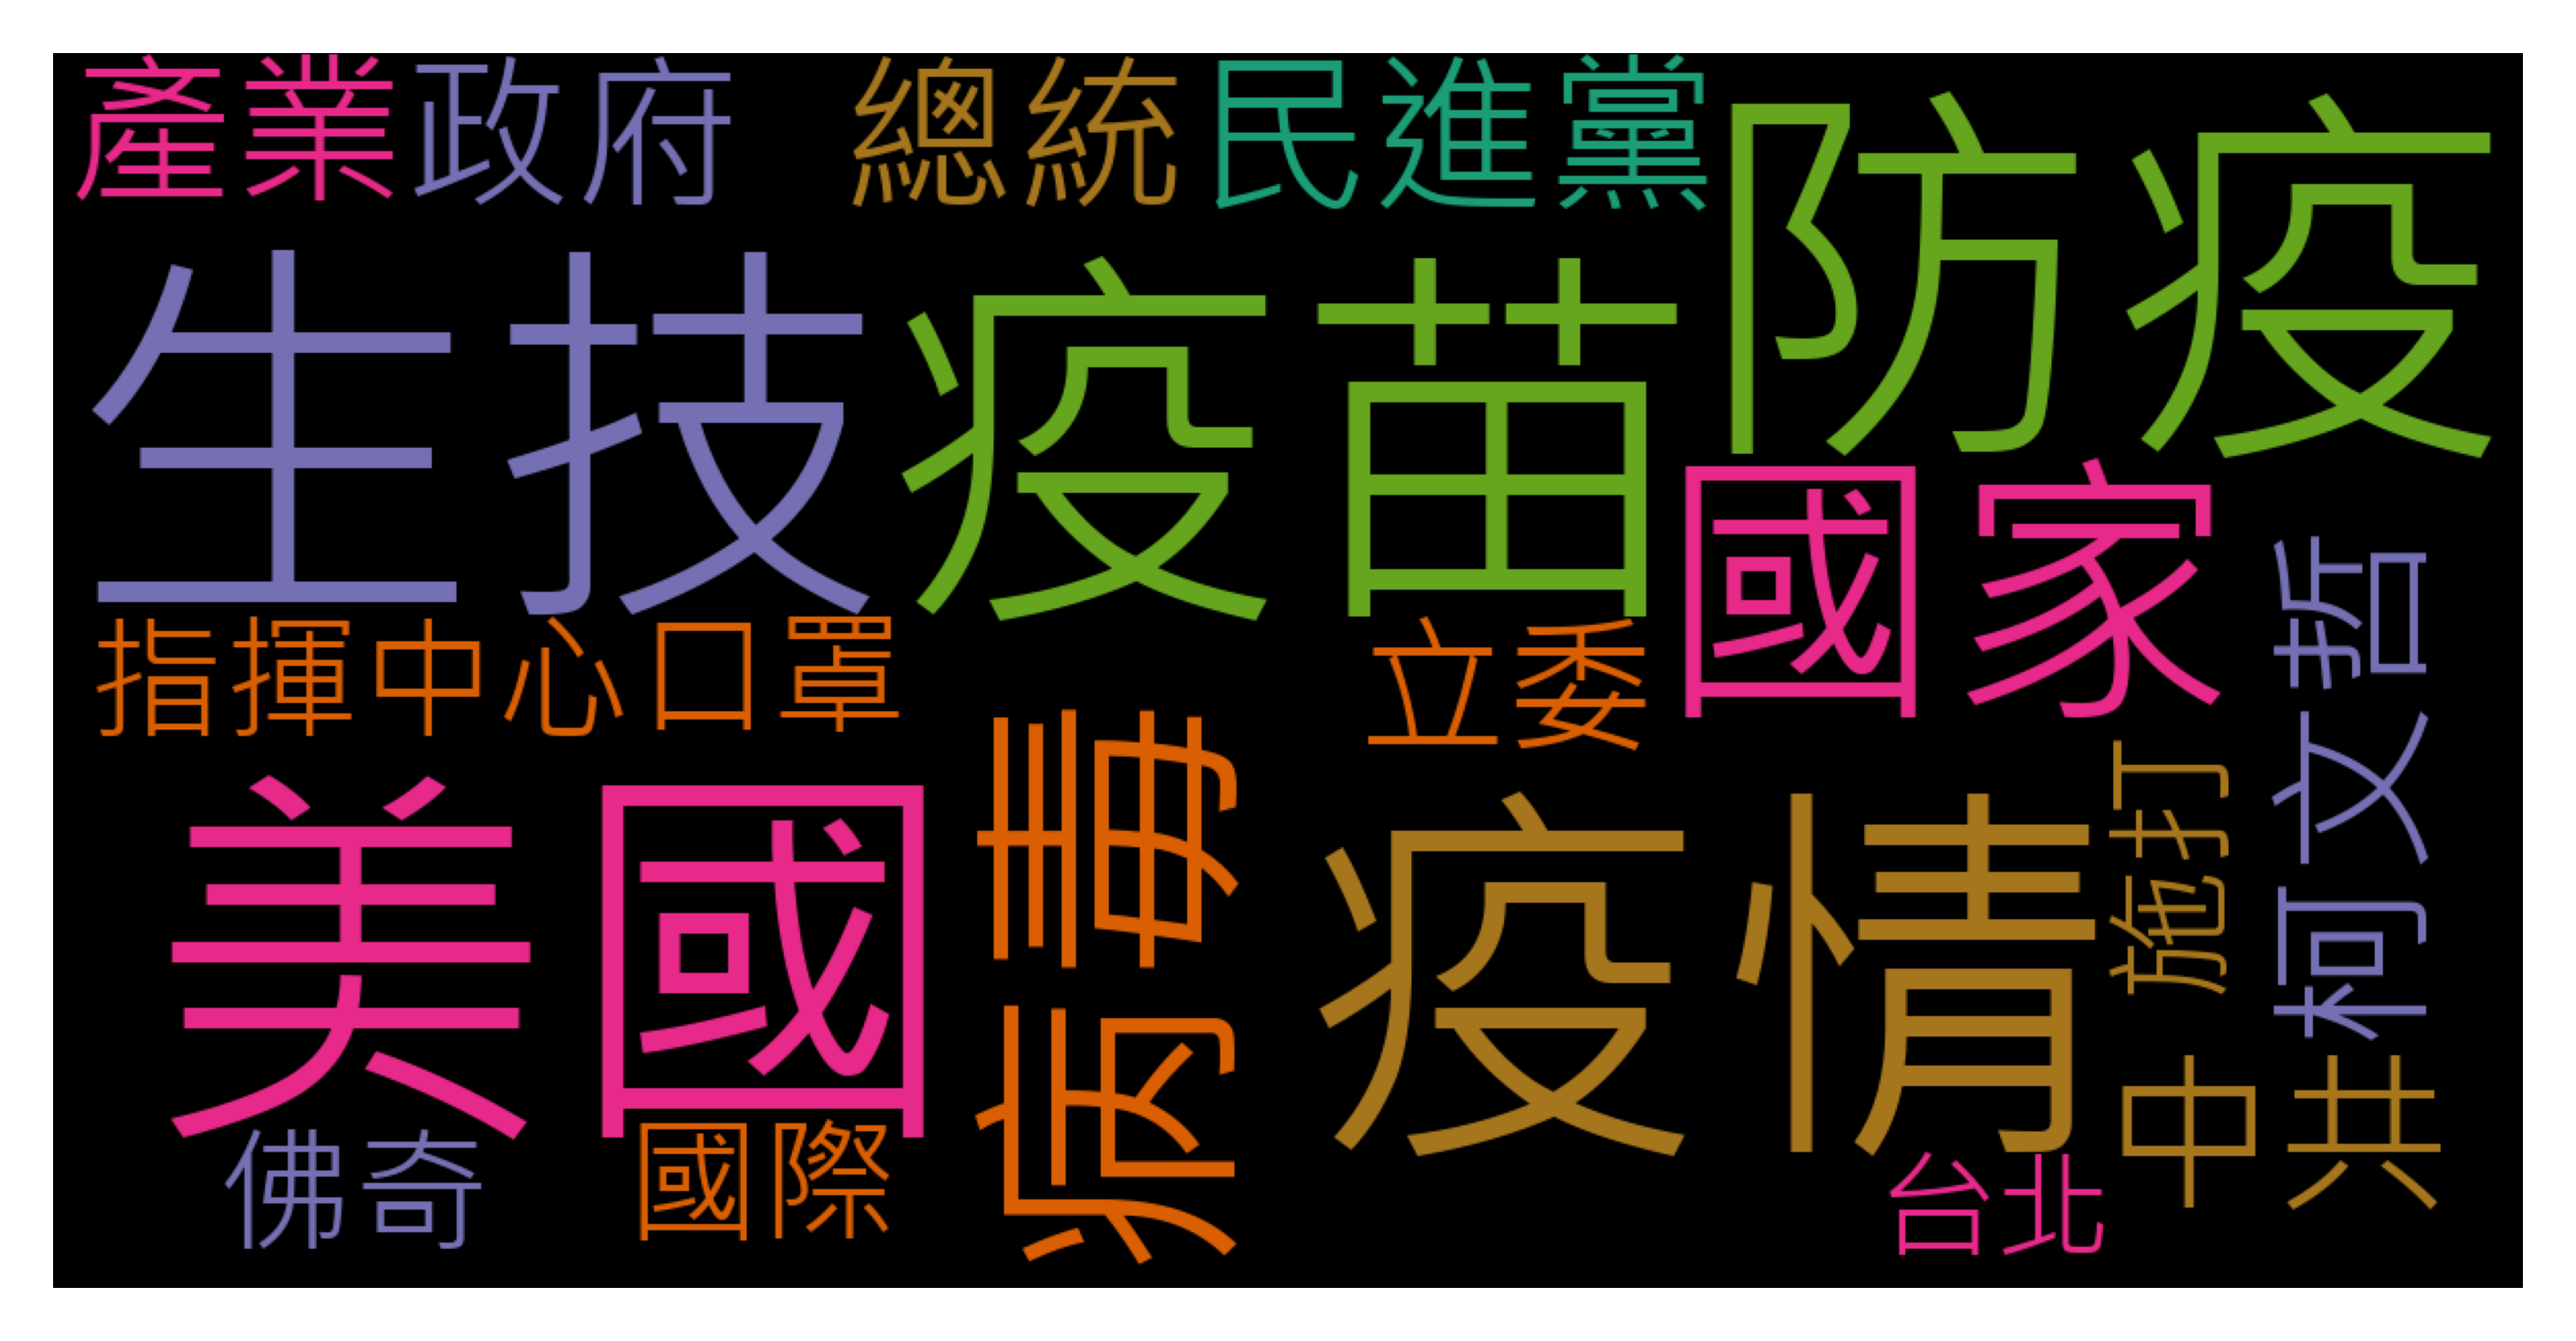

In [12]:
wordcloudPTT(content_tags)

In [13]:
content_pd.sort_values(by=['Times'], ascending = False)

,KeyWords,Times
0,疫苗,157
1,疫情,55
11,政府,38
2,美國,35
6,病毒,30
9,中共,25
4,防疫,21
3,生技,19
15,口罩,17
5,國家,16


In [14]:
comments[1]

{'push_tag': '推',
 'push_userid': 'kuninaka',
 'push_content': '不可能',
 'push_ipdatetime': '06/03 10:30'}

In [15]:
message_pd, message_tags = jiebaCount(comments, 'push_content', True, 40)

Building prefix dict from /Users/GaryWu/Desktop/Gary/OnlineCourse/Curop/Web_Crawler/Final/PTT/dict.txt.big ...
Loading model from cache /var/folders/fs/x3hrptr53y98cz67jm09n4mc0000gn/T/jieba.u9ec0ebec32d5ddd76c81146574223fdc.cache
Loading model cost 1.513 seconds.
Prefix dict has been built successfully.


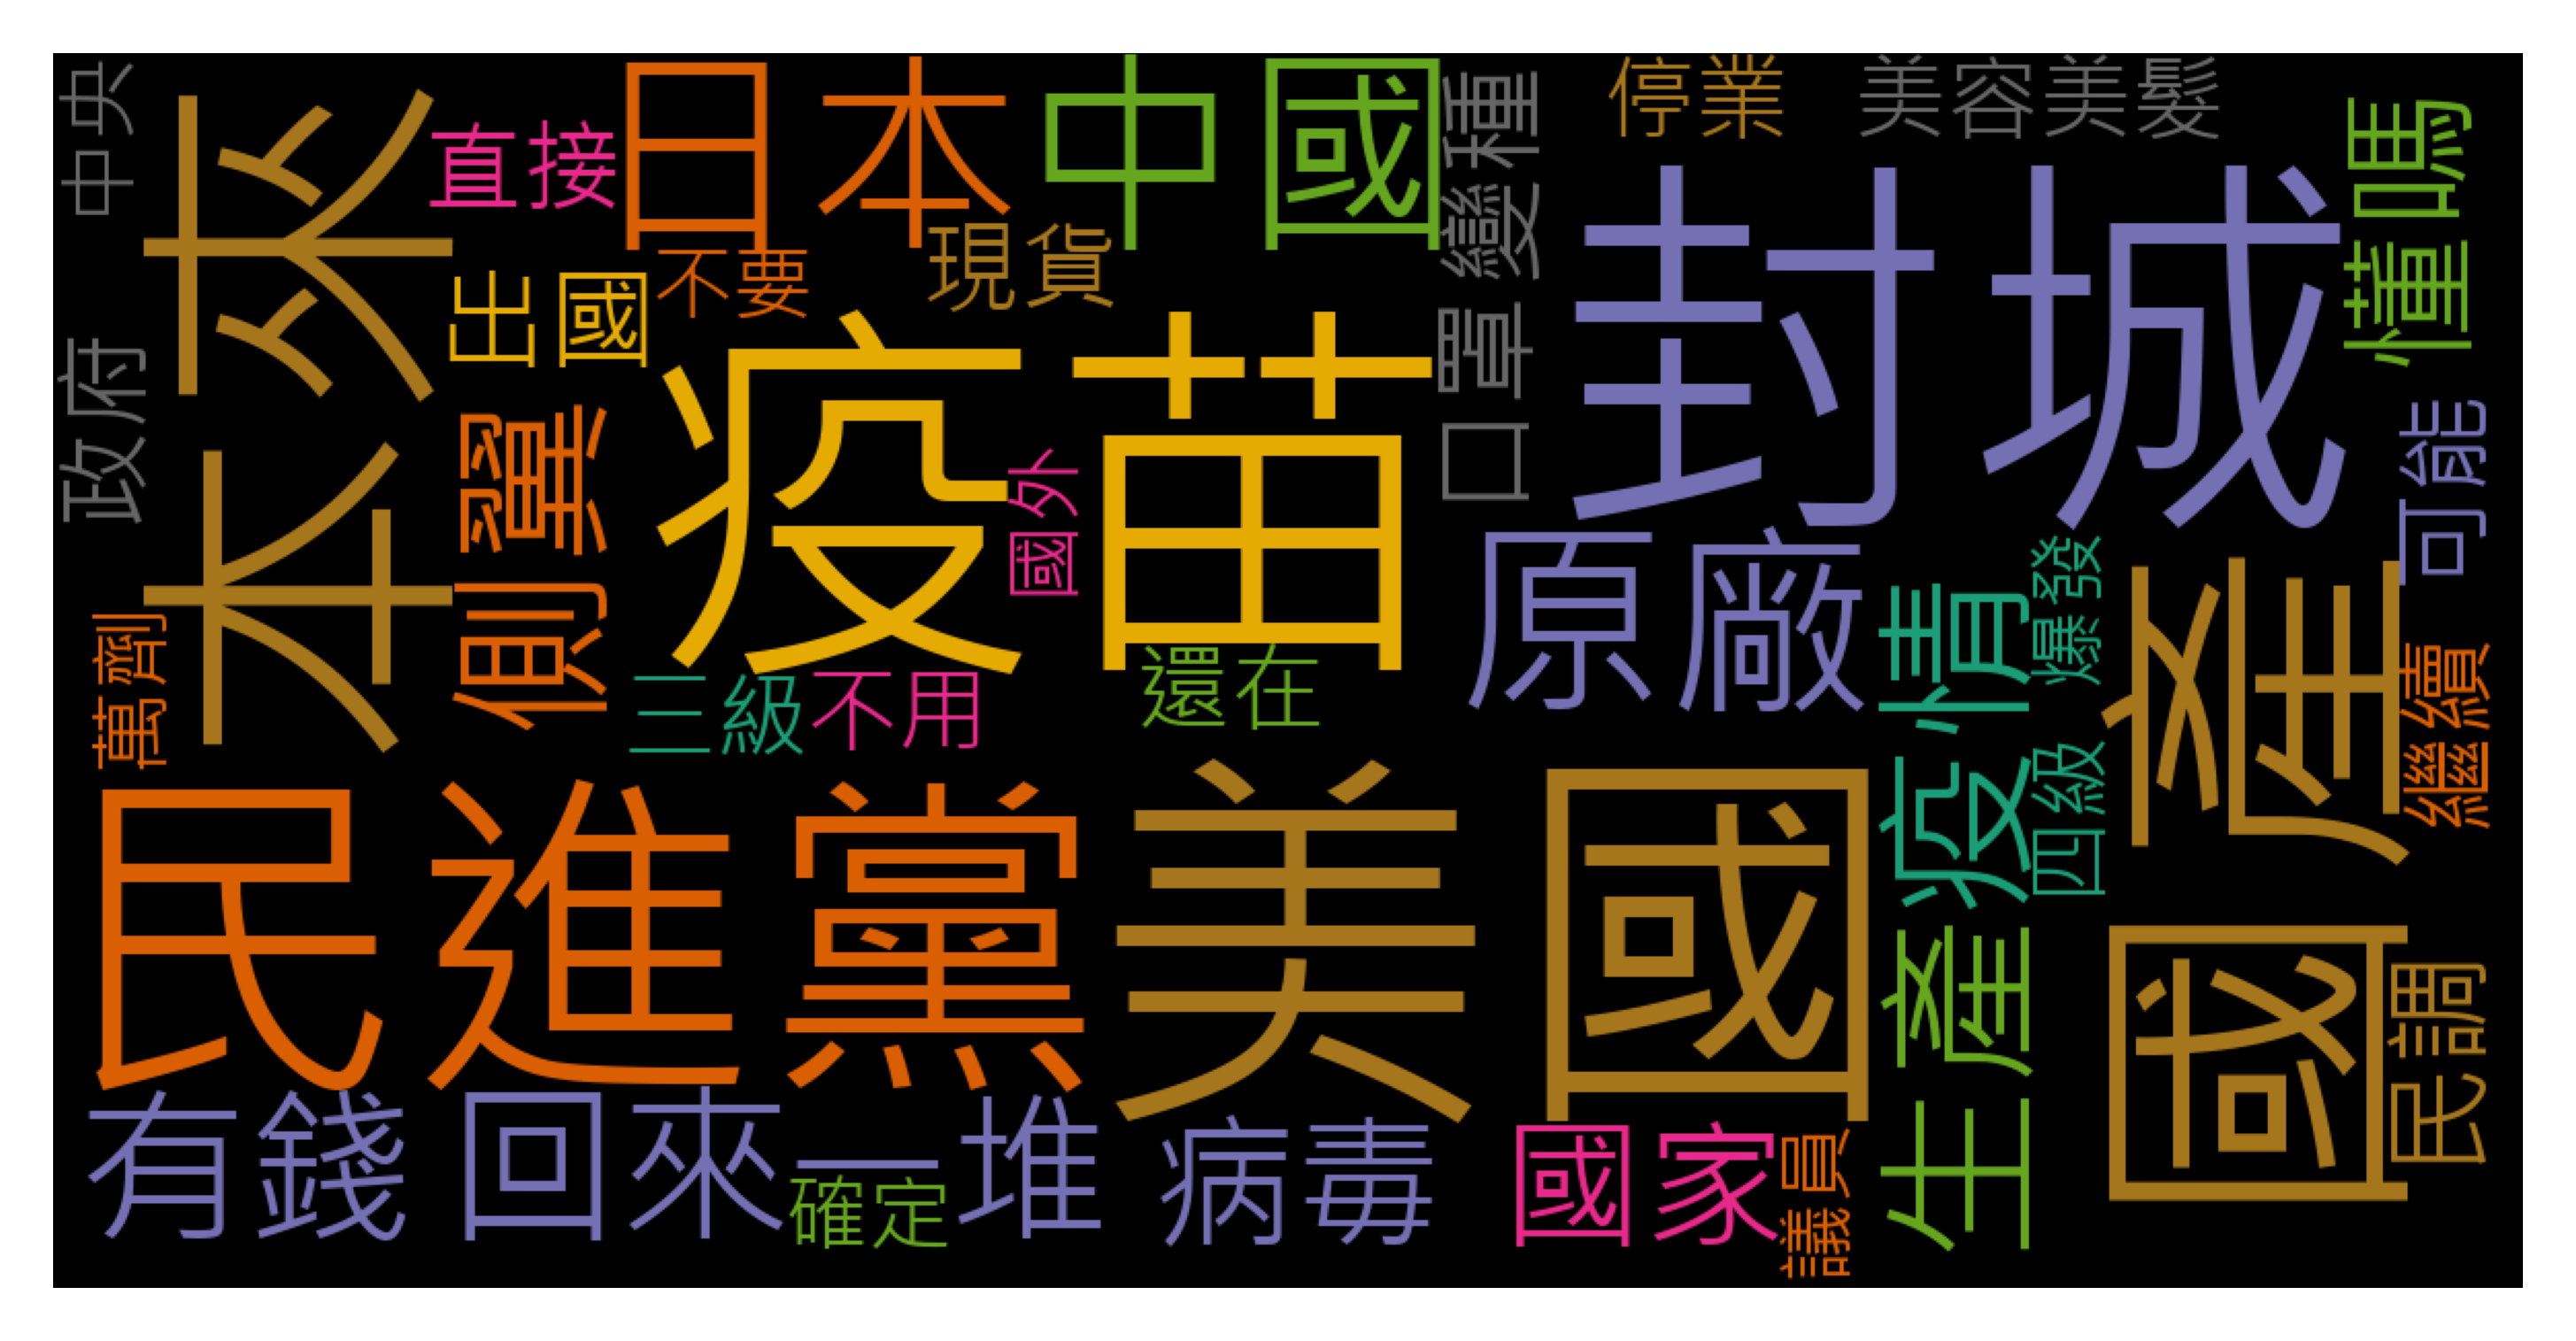

In [16]:
wordcloudPTT(message_tags)

In [17]:
commentpd = pd.DataFrame(comments)
commentpd.head(100)

,push_tag,push_userid,push_content,push_ipdatetime
0,推,s505015,聽說很早很早以前台積電想投資生技,06/03 10:30
1,推,kuninaka,不可能,06/03 10:30
2,→,s505015,但是報告的人用生物圖案 張覺得不倫不類,06/03 10:30
3,→,s505015,就告吹了 也就在自己本分投資,06/03 10:31
4,推,hellogym,笑死 想太多 台灣玩生技?? 不可能啦,06/03 10:31
...,...,...,...,...
95,推,eddisontw,其實這是很現實的問題啊 停越多行業 就要補助越多,06/03 10:37
96,推,frozenmoon,那為什麼之前想要升4級跟封城,06/03 10:37
97,噓,GGrunrundela,還好板上醜肥宅沒這困擾 醜男不用理髮ㄏㄏ,06/03 10:37
98,推,tony890415,我是覺得啦 18歲以上一人一萬 18以下5000啦,06/03 10:37


In [18]:
def articleCollect(inputpd, author, content, times):
        ## 整理每個推/發文id的全部發文
        ##     每個推/發文ip的全部id
        temp = []
        for name in inputpd[author]: # 抓每個發/推文者的id/ip
            if not name in temp:
                temp.append(name)
        tempD = pd.DataFrame(temp)   # 將每個發/推文者的id/ip預先變成dataframe以便後續填補資料
        tempD = tempD.rename({0:author}, axis='columns')
        temp = []       # 裝每個發/推文者的id/ip
        tempL = []      # 裝每個id/ip的推/發文數或推/發文人數
        allArticle = '' # 全部發文內容彙整 -> 了解最近大家關心的
        pdCount = 0
        for name in tempD[author]:
            temppd = inputpd[inputpd[author]==name]
            for detail in temppd[content]:
                if ('author' in author)*('article' in content):
                    allArticle += detail+' ' # 全部發文內容彙整 -> 了解最近大家關心的
                try:
                    if ('ip' in author):
                        if not detail in temp[pdCount]:
                            temp[pdCount] = temp[pdCount]+';'+detail        
                    else:
                        temp[pdCount] = temp[pdCount]+';'+detail        
                except:
                    temp.append(detail)     
            if ('ip' in author):
                tempL.append(len(temp[pdCount].split(';'))) # 拿到ip -> 整理此ip有幾人用
            else:
                tempL.append(len(temppd[content]))          # 沒拿到ip -> 整理此id發/推過幾篇文
            pdCount +=1
        tempD[content] = temp
        tempD[times] = tempL
        tempD = tempD.sort_values(by=times, ascending=False).reset_index()
        '''
        if ('author' in author)*('article' in content):  
            self.allArticle = allArticle
        '''
        return tempD

In [19]:
pddata = pd.DataFrame(data)
pdmessage = pd.DataFrame(comments)

In [20]:
pddata_byname = articleCollect(pddata, 'article_author_id', 'article_content', 'article_times')

In [21]:
pddata_byname

,index,article_author_id,article_content,article_times
0,0,andrewkuo,1.新聞網址 https://www.epochtimes.com/b5/21/6/2/n1...,3
1,8,JamesSoong,看到了沒? 有黨證的就是不一樣 客客氣氣請回 套個招讓你回去想想以後怎麼拆招\n ...,3
2,6,B0858B,目前臺灣沒有疫苗的窘境，藍白粉也該負點責任\n\n藍營選民不是很愛說同島一命嗎？怎麼國外有疫...,2
3,35,goetze,承包廠商的老闆兒子\n\n在自己公司別的案子跟業主開會\n\n事後發現有去開會的人確診\n\...,1
4,26,iamalexnotjo,被八卦桶了無法回文\n\n但機場真的爆大量啦\n\n昨天二航廈出境人數沒記錯應該是這一整年來...,1
5,27,anono,廣州日報記者近日的市政府新聞發布會上數次提到本次新冠肺炎疫情的特點十分\n突出病毒傳播速度快...,1
6,28,douglasjs,陳菊就等不住了啊\n\n 爆發一兩天就趕著打 https://reurl.cc/vq5Ym...,1
7,29,zizou,我覺得你洗這個風向\n根本就是不了解生技業\n\n生技業本身就是高投資\n然後只能0或100...,1
8,30,chungrew,看最近大家對邊境管制的討論熱度有所降低\n\n而且版上搜尋印度變種病毒(B.1.617.2)...,1
9,31,songgood,當初硬推韓出來選\n不但沒選上\n還讓郭董沒得選\n今天要是郭董當總統\n疫苗早就進來了\n...,1


In [22]:
def CollectInfo(inputData, author, content, times):
    authorList = list()
    
    for person in inputData[author]:
        if not person in authorList:
            authorList.append(person)
    
    tempPd = pd.DataFrame(authorList)
    tempPd = tempPd.rename({0:author}, axis='columns')
    
    allArticles = ''
    count = 0
    user_id = []       # 裝每個發/推文者的id/ip
    articleCount = []      # 裝每個id/ip的推/發文數或推/發文人數
    
    
    for person in authorList:
        tempData = inputData[inputData[author] == person]
        
        for info in tempData[content]:
            allArticles += info + ' '
            
            if len(user_id) > count:
                user_id[count] = user_id[count] + ';' + info
            else:
                user_id.append(info)
            
        articleCount.append(len(tempData[content]))
        count += 1
    
    tempPd[content] = user_id
    tempPd[times] = articleCount
    tempPd = tempPd.sort_values(by=times, ascending=False).reset_index()
    
    return tempPd


In [23]:
hi = pddata[pddata['article_author_id'] == 'neutron']
count = 0
user_id = []

for info in hi['article_content']:

    if len(user_id) > count:
        user_id[count] = user_id[count] + ';' + info
    else:
        user_id.append(info)
    print(info)
    print('**************')
    
    count += 1

In [24]:
pddata_info = CollectInfo(pddata, 'article_author_id', 'article_content', 'article_times')
comment_data = CollectInfo(commentpd, 'push_userid', 'push_content', 'push_times')

In [25]:
pddata_info

,index,article_author_id,article_content,article_times
0,0,andrewkuo,1.新聞網址 https://www.epochtimes.com/b5/21/6/2/n1...,3
1,8,JamesSoong,看到了沒? 有黨證的就是不一樣 客客氣氣請回 套個招讓你回去想想以後怎麼拆招\n ...,3
2,6,B0858B,目前臺灣沒有疫苗的窘境，藍白粉也該負點責任\n\n藍營選民不是很愛說同島一命嗎？怎麼國外有疫...,2
3,35,goetze,承包廠商的老闆兒子\n\n在自己公司別的案子跟業主開會\n\n事後發現有去開會的人確診\n\...,1
4,26,iamalexnotjo,被八卦桶了無法回文\n\n但機場真的爆大量啦\n\n昨天二航廈出境人數沒記錯應該是這一整年來...,1
5,27,anono,廣州日報記者近日的市政府新聞發布會上數次提到本次新冠肺炎疫情的特點十分\n突出病毒傳播速度快...,1
6,28,douglasjs,陳菊就等不住了啊\n\n 爆發一兩天就趕著打 https://reurl.cc/vq5Ym...,1
7,29,zizou,我覺得你洗這個風向\n根本就是不了解生技業\n\n生技業本身就是高投資\n然後只能0或100...,1
8,30,chungrew,看最近大家對邊境管制的討論熱度有所降低\n\n而且版上搜尋印度變種病毒(B.1.617.2)...,1
9,31,songgood,當初硬推韓出來選\n不但沒選上\n還讓郭董沒得選\n今天要是郭董當總統\n疫苗早就進來了\n...,1


In [26]:
comment_data

,index,push_userid,push_content,push_times
0,1,kuninaka,不可能;台灣這麼小 很難搞出第二個護國世界級產業;中央應該紓困;停班停業的一個月發三萬;停班...,49
1,18,taipoo,這是自己的心魔問題，自己要想辦法克服才對;民進黨的官官相護，真的很難看;真的是民進黨政府太白...,37
2,51,hanslins,喊封城的又不是柯;沒全台灣一起封一點機會都沒有，即使全台一起封成功機;會也很小;桃園確定到6...,33
3,55,skyexers,整天打美容美髮到底幹嘛 除非你家都沒有女人啦;去側翼的臉書可能有;武漢腦真多 滿子封城封城;...,25
4,22,jorden,基隆感覺不妙.....;跟你講 現在是阿北阿棒棒時間 不准汙衊;阿北都是對的 千萬不要嘴;去...,23
...,...,...,...,...
312,216,Jimmywin,有錢判生,1
313,215,darkbbyy,有啥好酸的...就算自己抗中飽台不打 好歹送長輩去打吧,1
314,214,ZanyLuna,去年也一堆人逃來台灣啦,1
315,128,dogluckyno1,站在風頭上，不然他怎麼可能選贏那麼多次,1
